# 앙상블 모델
- 배깅: 데이터를 랜덤하게 (다양하게) 사용하는 것 (예 랜덤 포레스트)
- 부스팅: 모델을 순차적으로 개선하는 것 (예, xgboost, lightgbm)
- 스태킹: 여러 다양한 모델의 결과를 취합하는 것

<img src="https://github.com/StillWork/image/blob/main/%E1%84%89%E1%85%B3%E1%84%8F%E1%85%B3%E1%84%85%E1%85%B5%E1%86%AB%E1%84%89%E1%85%A3%E1%86%BA%202021-05-29%20%E1%84%8B%E1%85%A9%E1%84%92%E1%85%AE%208.49.26.png?raw=1" align='left' width=500>

<img src="https://github.com/StillWork/image/blob/main/%E1%84%89%E1%85%B3%E1%84%8F%E1%85%B3%E1%84%85%E1%85%B5%E1%86%AB%E1%84%89%E1%85%A3%E1%86%BA%202021-05-29%20%E1%84%8B%E1%85%A9%E1%84%92%E1%85%AE%208.53.39.png?raw=1" align='left' width=500>

# 배깅
- "같은" 모델을 사용하고 데이터를 무작위로 달리 사용한다
- 배깅: 중복허용 (bootstrap aggregation)
- 병렬로 처리할 수 있다
- 랜덤 포레스트는 배깅을 적용한 결정트리 앙상블 기법

# 부스팅

## 그라디언트 부스팅
- 그라디언트 부스팅에서는 앞단계 모델의 "예측 오차"를 예측하는 모델을 만든다
- 즉, y가 아니라 e를 예측하는 모델을 계속 만드는 작업을 한다.
- 각 단계의 "간단한" 모델로 결정트리를 사용한다

In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [4]:
# 샘플 데이터 생성
N = 100
np.random.seed(42)
X = np.random.rand(N, 1) - 0.5
y = 3*X[:, 0]**2 + 0.05 * np.random.randn(N) 
# y = 3*x^2 + noise

In [5]:
X[:3]

array([[-0.12545988],
       [ 0.45071431],
       [ 0.23199394]])

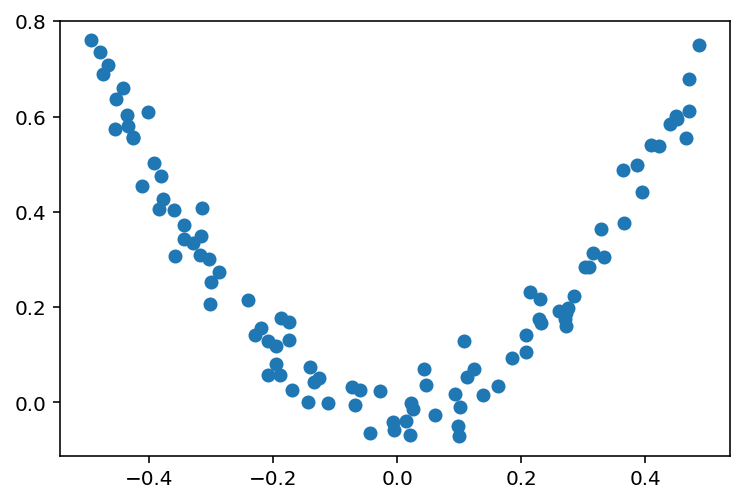

In [6]:
plt.scatter(X,y)

In [7]:
#  X -> y 간단한 예측기
from sklearn.tree import DecisionTreeRegressor

tree_reg1 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg1.fit(X, y)

DecisionTreeRegressor(max_depth=2, random_state=42)

In [8]:
# X -> e 예측기 (e는 오차)
e = y - tree_reg1.predict(X)
tree_reg2 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg2.fit(X, e)

DecisionTreeRegressor(max_depth=2, random_state=42)

In [9]:
# X -> e2 예측기 (e2는 오차의 오차)

e2 = e - tree_reg2.predict(X)
tree_reg3 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg3.fit(X, e2)

DecisionTreeRegressor(max_depth=2, random_state=42)

In [10]:
X_sample = np.array([[-0.3], [0], [0.2]])

# 3개의 모델의 합을 구한다
y_pred = sum(tree.predict(X_sample) for tree in (tree_reg1, tree_reg2, tree_reg3))
y_pred # y = 3*x^2 + noise

array([0.29044761, 0.04021166, 0.17052257])

In [10]:
def plot_predictions(regressors, X, y, axes, label=None, style="r-", data_style="b.", data_label=None):
    x1 = np.linspace(axes[0], axes[1], 500)
    y_pred = sum(regressor.predict(x1.reshape(-1, 1)) for regressor in regressors)
    plt.plot(X[:, 0], y, data_style, label=data_label)
    plt.plot(x1, y_pred, style, linewidth=2, label=label)
    if label or data_label:
        plt.legend(loc="upper center", fontsize=16)
    plt.axis(axes)

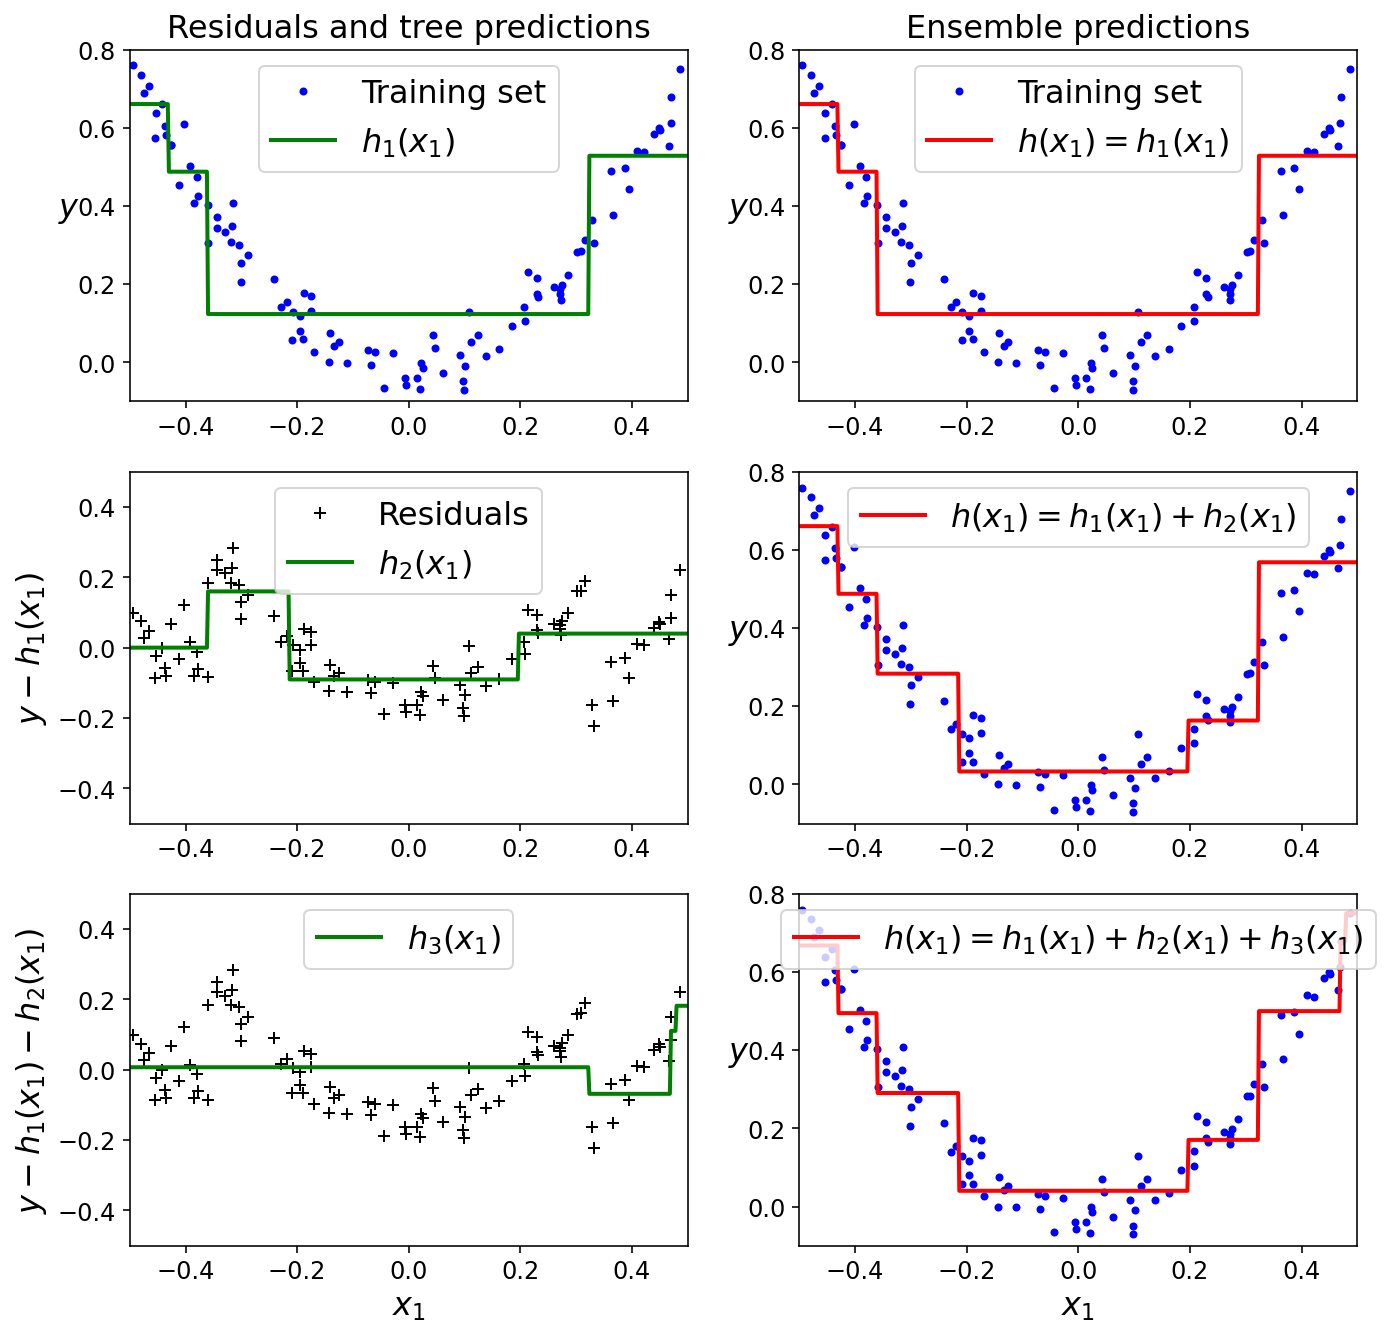

In [11]:
plt.figure(figsize=(11,11))

plt.subplot(321)
plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h_1(x_1)$", style="g-", data_label="Training set")
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.title("Residuals and tree predictions", fontsize=16)

plt.subplot(322)
plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1)$", data_label="Training set")
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.title("Ensemble predictions", fontsize=16)

plt.subplot(323)
e = y - tree_reg1.predict(X)
plot_predictions([tree_reg2], X, e, axes=[-0.5, 0.5, -0.5, 0.5], label="$h_2(x_1)$", style="g-", data_style="k+", data_label="Residuals")
plt.ylabel("$y - h_1(x_1)$", fontsize=16)

plt.subplot(324)
plot_predictions([tree_reg1, tree_reg2], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1) + h_2(x_1)$")
plt.ylabel("$y$", fontsize=16, rotation=0)

plt.subplot(325)
e2 = y - tree_reg1.predict(X)
plot_predictions([tree_reg3], X, e2, axes=[-0.5, 0.5, -0.5, 0.5], label="$h_3(x_1)$", style="g-", data_style="k+")
plt.ylabel("$y - h_1(x_1) - h_2(x_1)$", fontsize=16)
plt.xlabel("$x_1$", fontsize=16)

plt.subplot(326)
plot_predictions([tree_reg1, tree_reg2, tree_reg3], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1) + h_2(x_1) + h_3(x_1)$")
plt.xlabel("$x_1$", fontsize=16)
plt.ylabel("$y$", fontsize=16, rotation=0)

plt.show()

- 좌측은 예측기의 순차적인 동작을 설명
- 우측은 앙상블의 예측 (합)을 보여준다

### XGBoost
- 성능이 향상된 모델, extreme gb

### LightGBM 
- XGBoost를 개선한 모델

# 스태킹
- Stacking
- 투표기반 분류기
- 여러가지 모델을 사용하여 예측을 하고 각 결과를 취합하는 방법
- 직접 투표 또는 간접투표를 선택할 수 있다

## 데이터
- Two Moon Data

In [17]:
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
X, y = make_moons(n_samples=500, noise=0.35, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

(375, 2)


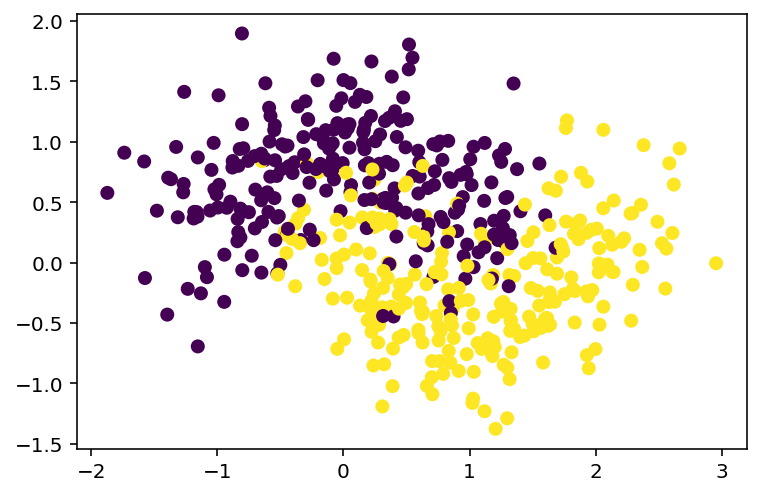

In [18]:
print(X_train.shape)
plt.scatter(X[:,0], X[:,1], c=y)

## 선형분류, 로지스틱회귀, 결정트리, kNN

In [19]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

lin_clf = SGDClassifier()
dt_clf = DecisionTreeClassifier()
log_clf = LogisticRegression(solver="lbfgs", random_state=42)
rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42)
svm_clf = SVC(gamma="scale", random_state=42)

## 직접 투표

In [20]:
voting_clf = VotingClassifier(
    estimators=[('linear', lin_clf),('dt', dt_clf),('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting='hard')

In [21]:
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('linear', SGDClassifier()),
                             ('dt', DecisionTreeClassifier()),
                             ('lr', LogisticRegression(random_state=42)),
                             ('rf', RandomForestClassifier(random_state=42)),
                             ('svc', SVC(random_state=42))])

In [22]:
from sklearn.metrics import accuracy_score

for clf in (lin_clf, dt_clf, log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

SGDClassifier 0.848
DecisionTreeClassifier 0.84
LogisticRegression 0.848
RandomForestClassifier 0.864
SVC 0.848
VotingClassifier 0.856


## 간접 투표
- SVC는 클래스 확률을 제공하지 않으므로 이를 얻으려면 명시적으로 probabbility=True를 지정해야 한다 (단, 클래스 확률을 구하기 위해서 교차검증을 해야 하고 속도는 느려진다)


In [23]:
log_clf = LogisticRegression(solver="lbfgs", random_state=42)
rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42)
svm_clf = SVC(gamma="scale", probability=True, random_state=42)

voting_clf = VotingClassifier(
    estimators=[('dt', dt_clf), ('lr', log_clf),('rf', rnd_clf), ('svc', svm_clf)],
    voting='soft')
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('dt', DecisionTreeClassifier()),
                             ('lr', LogisticRegression(random_state=42)),
                             ('rf', RandomForestClassifier(random_state=42)),
                             ('svc', SVC(probability=True, random_state=42))],
                 voting='soft')

In [24]:
from sklearn.metrics import accuracy_score

for clf in (dt_clf, log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

DecisionTreeClassifier 0.808
LogisticRegression 0.848
RandomForestClassifier 0.864
SVC 0.848
VotingClassifier 0.856
